In [19]:
#Separate notebook to work on Topic Modelling with LDA
%pylab inline
from sys import platform
import pandas as pd

if platform == "win32":
    path = 'C:/Users/olive/'
elif platform == "darwin":
    path = '~/'

Populating the interactive namespace from numpy and matplotlib


In [20]:
c_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/comments.csv')
s_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/submissions.csv')

s_df = s_df.sort_values(by='datetime')
c_df = c_df.sort_values(by='datetime')

In [21]:
comments = c_df.reset_index().drop(columns=['id', 'datetime', 'sentiment', 'compound_score', 'submission_id', 'parent_id'], axis=1)

comments = comments.sample(100)

comments.head()

,body
243297,I'm still working full time as my job hasn't r...
340855,But the year groups being sent home will have ...
405173,I’d noticed the same difference for Greater Ma...
353116,Thanks for your story. How did you end up with...
530275,"Agree with this, while one or two social circl..."


In [22]:
# Remove punctuation
import re

comments['processed_text'] = comments['body'].map(lambda x: re.sub('[,\.!?]', '', x))

comments['processed_text'] = comments['processed_text'].map(lambda x: x.lower())

comments['processed_text'].head()

243297    i'm still working full time as my job hasn't r...
340855    but the year groups being sent home will have ...
405173    i’d noticed the same difference for greater ma...
353116    thanks for your story how did you end up witho...
530275    agree with this while one or two social circle...
Name: processed_text, dtype: object

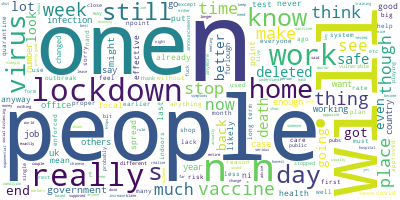

In [23]:
# EXPLORATORY ANALYSIS

from wordcloud import WordCloud

long_string = ','.join(list(comments['processed_text'].values))

wordcloud = WordCloud(background_color="white",
                      max_words=5000,
                      contour_width=3,
                      contour_color='steelblue'
                     )

wordcloud.generate(long_string)

wordcloud.to_image()

In [24]:
# Tokenize words and more text clean-up

import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),
                                            deacc=True))
data = comments.processed_text.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['still', 'working', 'full', 'time', 'as', 'my', 'job', 'hasn', 'really', 'changed', 'at', 'all', 'except', 'that', 'always', 'at', 'home', 'of', 'course', 'in', 'fact', 'it', 'has', 'changed', 'because', 'lot', 'more', 'of', 'the', 'companies']


In [25]:
#Bigram and Trigram Phrase Modelling

bigram = gensim.models.Phrases(
    data_words, min_count=5, threshold=100
)
trigram = gensim.models.Phrases(
    bigram[data_words], threshold=100
)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [26]:
#Remove Stopwords, Make Bigrams and Lemmantize

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [27]:
#Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [28]:
import spacy

data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load("en_core_web_sm", disable=['parser',
                                            'ner'])

data_lemmatized = lemmatization(data_words_bigrams, 
                                allowed_postags=['NOUN', 
                                                 'ADJ', 
                                                 'VERB', 
                                                 'ADV'])

print(data_lemmatized[:1])

[['still', 'work', 'full', 'time', 'job', 'really', 'change', 'always', 'home', 'course', 'fact', 'change', 'lot', 'company', 'work', 'depend', 'work', 'extra', 'hour', 'rest', 'staff', 'job', 'put', 'top', 'furlough', 'think', 'furlough', 'scheme', 'fantastic', 'glad', 'work', 'company', 'top', 'little', 'motivation', 'work', 'hard', 'see', 'colleague', 'social', 'medium', 'party', 'day', 'play', 'xbox', 'certainly', 'job', 'return', 'calm', 'put', 'furlough', 'becayse', 'work', 'moment', 'well']]


In [29]:
#Data Tranformation: Corpus and Dictionary

import gensim.corpora as corpora

id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 3), (15, 1), (16, 1), (17, 1), (18, 1), (19, 3), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 6), (41, 1)]]


In [30]:
from pprint import pprint

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.033*"work" + 0.021*"home" + 0.021*"job" + 0.017*"office" + 0.013*"back" + '
  '0.013*"furlough" + 0.010*"think" + 0.009*"get" + 0.009*"blood" + '
  '0.009*"manage"'),
 (1,
  '0.020*"number" + 0.015*"exponential" + 0.015*"find" + 0.010*"test" + '
  '0.010*"fuck" + 0.010*"infection" + 0.010*"claim" + 0.010*"mean" + '
  '0.010*"last" + 0.010*"curve"'),
 (2,
  '0.014*"people" + 0.013*"say" + 0.010*"get" + 0.010*"go" + 0.010*"day" + '
  '0.010*"shop" + 0.010*"announcement" + 0.007*"make" + 0.007*"want" + '
  '0.007*"stop"'),
 (3,
  '0.018*"really" + 0.015*"home" + 0.012*"miss" + 0.012*"other" + 0.012*"good" '
  '+ 0.011*"work" + 0.009*"lockdown" + 0.009*"run" + 0.009*"get" + '
  '0.009*"tory"'),
 (4,
  '0.020*"people" + 0.014*"close" + 0.014*"npoint" + 0.014*"know" + '
  '0.014*"work" + 0.010*"get" + 0.010*"day" + 0.010*"point" + 0.010*"country" '
  '+ 0.010*"really"'),
 (5,
  '0.016*"good" + 0.011*"know" + 0.011*"go" + 0.011*"quarantine" + '
  '0.011*"back" + 0.011*"cloud" + 0.01

In [31]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.38819664403441295


In [32]:
#Hyperparameter Tuning

def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    print(corpus)
    print(dictionary)
    print(k)
    print(a)
    print(b)
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=data_lemmatized, 
                                         dictionary=id2word,
                                         coherence='c_v')
    
    return coherence_model_lda.get_coherence()


In [33]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

#Can take a while to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], 
                                                  dictionary=id2word, 
                                                  k=k, 
                                                  a=a,
                                                  b=b)
                    print('Alert')
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
                    
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv',
                                       index=False)
    pbar.close()


  0%|          | 0/540 [00:00<?, ?it/s]

ValueError: Stop argument for islice() must be None or an integer: 0 <= x <= sys.maxsize.